<a href="https://colab.research.google.com/github/vignesh-pala/NLP/blob/master/NL_Keras_Ch9_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Challenge 9 (NLP with Deep Learning)**

 

The last challenge (Challenge 8) dealt about achieving a model accuracy of around 80% in the multi class prediction for reuters dataset.

 

Here are few things we can do now.  Please try to implement them.

1. See if L1 / L2 regularizers can improve the accuracy.

2. Separate 10% data from train data and use it as validation set.  Plot the accuracy for train data and validation data against the no of epochs.

3. Use test data to predict the accuracy % of the model 

In [1]:
#import Tensorflow.Keras libraries
import tensorflow 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.datasets import reuters
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers, backend
from keras.utils import np_utils

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
max_words = 5000

In [3]:
# split into Train, Test and Validation set
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words, test_split=0.1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

#word_index = reuters.get_word_index(path="reuters_word_index.json")
print(x_train[0])

2113536/2110848 [==============================] - 0s 0us/step
[1, 53, 996, 26, 14, 924, 26, 39, 19, 2, 18, 14, 19, 3302, 18, 86, 187, 63, 11, 14, 160, 59, 11, 17, 12]


In [4]:
tokenizer = Tokenizer(num_words=max_words)
x_train_tkn = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test_tkn = tokenizer.sequences_to_matrix(x_test, mode='binary')
x_val_tkn = tokenizer.sequences_to_matrix(x_val, mode='binary')
print(x_train_tkn[0])

[0. 1. 1. ... 0. 0. 0.]


Convert labels to one-hot encoded fields, so each field represents a label

In [5]:
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)
y_val_cat = np_utils.to_categorical(y_val)

categories = len(y_train_cat[0])

print('Total categories = {}'.format(categories))

Total categories = 46


**Pad Sequences**

* Keras prefers inputs to be vectorized and all inputs to have the same length.
So we need to fill in the remaining length with '0' to make the vector length uniform across the dataset.
* To acheive this, we use the pad_sequences()
Note: padding='post' ensures the 0 padding is done at the end of each record

In [6]:
x_train_pad = preprocessing.sequence.pad_sequences(x_train_tkn, maxlen=max_words,  padding='post')
x_test_pad = preprocessing.sequence.pad_sequences(x_test_tkn, maxlen=max_words,  padding='post')
x_val_pad = preprocessing.sequence.pad_sequences(x_val_tkn, maxlen=max_words,  padding='post')

**Model Building:**

**Weight Regularization in Keras:**
*	Reduces overfitting
*	A weight regularizer can be added to each layer 
*	Three different regularizer instances are provided; they are:
** L1: Sum of the absolute weights.
** L2: Sum of the squared weights.
**	L1L2: Sum of the absolute and the squared weights.
 
* Regularization can be applied to 3 areas within the layer.
**	kernel_regularizer, which applies regularization to the kernel a.k.a. the actual weights;
**	bias_regularizer, which applies regularization to the bias, which shifts the layer outputs;
**	activity_regularizer, which applies the regularizer to the output of the layer, i.e. the activation value (which is the combination of the weights + biases with the input vector, fed through the activation function
*	Ex:
from keras.regularizers import l2
model.add(Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01) ,kernel_regularizer= l2(0.0001)))


* Train the model and validate on the Validation set
* Dropout Layer: Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.


**Regularization results**

*   l1 regularization: performed very poorly. got validation accuracy as 57% only. 
*   l1_l2 regularization: same result as l1 regularization

* l2 regularization: val accuracy - 77% 

* l2 regularization(0.001): val accuracy - 79.4% 
* only with  bias_regularizer=l2(0.001)  got > 80% accuracy

**BatchNormalization**
* This layer will transform inputs so that they are standardized, meaning that they will have a mean of zero and a standard deviation of one
* Note: Adding BatchNormalization didnt show improvement, but added it for our learning. Also it doesn't harm the model

In [25]:
#Original Code:
backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(max_words,) ,kernel_regularizer= l2(0.0001)))
#model.add(BatchNormalization())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(categories, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit(x_train_pad, y_train_cat,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_val_pad, y_val_cat), callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280256   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                11822     
Total params: 1,292,078
Trainable params: 1,292,078
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
143/143 [==============================] - 3s 23ms/step - loss: 1.3834 - accuracy: 0.7064 - val_loss: 1.0009 - val_accuracy: 0.7953
Epoch 2/10
143/143 [==============================] - 3s 22ms/step - loss: 0.7672 - accuracy: 0.8433 - val_loss: 0.8693 - val_accuracy: 0.8051
Epoch 3/10
143/143 [==============================] - 3s 23ms/step - loss: 0.5603 - accura

**Plotting the results**

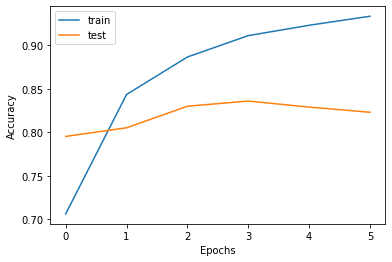

In [26]:
# plot history
# summarize history for accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.legend()
pyplot.show()

**As you can see i the graph, the model is overfitting on the train data. Lets add another drop out layer and see...**

In [22]:
backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(max_words,) ,kernel_regularizer= l2(0.0001)))
#model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(categories, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit(x_train_pad, y_train_cat,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_val_pad, y_val_cat), callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280256   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                11822     
Total params: 1,292,078
Trainable params: 1,292,078
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
143/143 [==============================] - 3s 23ms/step - loss: 1.6806 - accuracy: 0.6332 - val_loss: 1.1917 - val_accuracy: 0.7498
Epoch 2/10
143/143 [==============================] - 3s 23ms/step - loss: 1.1138 - accuracy: 0.7609 

**Plotting the results**

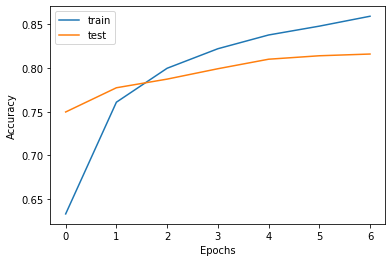

In [23]:
# plot history
# summarize history for accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.legend()
pyplot.show()

After adding two  Dropout layers, the model seems to be learning the data well as the Train and test set accuracies are close to each other.

**Further improvement:**
As you can notice in the graph, 
* validation accuracy is flat after 4 epochs.
* also the difference on train and test accuracy is increasing after 4th Epochs

so we can limit the training process to 4 epochs.

**Evaluate the model on Test data**

In [27]:
results = model.evaluate(x_test_pad, y_test_cat, batch_size=64)
print("test loss = {}\ntest accuracy = {}".format(results[0], results[1]))

18/18 [==============================] - 0s 7ms/step - loss: 0.9937 - accuracy: 0.8050
test loss = 0.9936931133270264
test accuracy = 0.8049866557121277


**Summary**

* Tried L1, L2, L1_L2 regularization on kernel_regularizer and Bias_regularizer
* Tried Batch Normalization 
* Accuracy slightly improved on L2 regularization on kernel_regularizer
* Batch Normalization didnt show improvement.
* Adding Layers also didnt show improvement

* Max Validation accuracy : 83.48%
* Test data accuracy: 80.58%

* Added another droput layer to avoid overfitting
* Limitted # of Epochs as mentioned above